In [78]:
import torch
import torchvision
from torch import nn
from torch.nn.functional import relu
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torchvision.datasets import VisionDataset
from torch.utils.data import DataLoader
# from torchvision.transforms import ToTensor
from torchinfo import summary
import time
# import tqdm

import pandas as pd
import numpy as np

import os
# import glob
# import math
# import imageio
import nibabel as nib
from tqdm.auto import tqdm
# from PIL import Image
from random import choice


In [79]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(DEVICE)

PIN_MEMORY = True if DEVICE == "cuda" else False
DEVICE, PIN_MEMORY

('cpu', False)

In [80]:
# Here we set all the hyper parameters

NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

LR = 0.0001
NUM_EPOCHS = 10
BATCH_SIZE = 4
NUM_WORKERS = 0

INPUT_IMAGE_HEIGHT = 572
INPUT_IMAGE_WIDTH = 572

THRESHOLD = 0.5

BASE_OUTPUT = "output"

mask_dir= "C:/Users/HP/Desktop/2024 projects/LiTS/data/segmentations"

root_dir = "C:/Users/HP/Desktop/2024 projects/LiTS/data"
scan_dir1 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt1"
scan_dir2 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt2"
scan_dir3 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt3"
scan_dir4 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt4"
scan_dir5 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt5"
scan_dirs = [scan_dir1, scan_dir2, scan_dir3, scan_dir4, scan_dir5]
len(scan_dirs)

5

In [81]:
walk_list= []
mask_walk= []
data_dir_list= []
mask_dir_list = []
"""
for item in os.walk(scan_dir1):
    walk_list.append(item)

"""
for dir in scan_dirs:
    for file_name in os.walk(dir):
        walk_list.append(file_name)

for file_name in os.walk(mask_dir):
    mask_walk.append(file_name)

for i in range(len(mask_walk[0][2])):
    mask_dir_list.append(mask_dir + "/" + str(mask_walk[0][2][i]))

for i in range(51):
    if i <= 10:
        data_dir_list.append(root_dir + "/volume_pt1/" +str(walk_list[0][2][i]))
    elif i > 10 and i <= 20:
        data_dir_list.append(root_dir + "/volume_pt2/" + str(walk_list[1][2][10-i]))
    elif i > 20 and i <= 30:
        data_dir_list.append(root_dir + "/volume_pt3/" + str(walk_list[2][2][20-i]))
    elif i > 30 and i <= 40:
        data_dir_list.append(root_dir + "/volume_pt4/" + str(walk_list[3][2][30-i]))
    elif i > 40 and i <= 50:
        data_dir_list.append(root_dir + "/volume_pt5/" + str(walk_list[4][2][40-i]))

train_set, test_set = torch.utils.data.random_split(data_dir_list, [0.8, 0.2])
train_mask, test_mask = torch.utils.data.random_split(mask_dir_list, [0.8, 0.2])

In [6]:

img = nib.load(train_set[3])
# img = img.astype(np.float32)

print(img.get_fdata().shape)
print(img.dataobj[:,:,:].shape)
#print(img.header)

(512, 512, 845)
(512, 512, 845)


In [73]:
def loadNifti1Image(path):
    image_data = nib.load(path).dataobj[:, :, 2]
    image_float = image_data.astype(np.float32)
    add_color_channel = np.stack([image_float] * 3, axis=0)
    tensor_format = torch.from_numpy(add_color_channel)

    return tensor_format

In [74]:
# Creating the custom segmentation dataset class    
class SegmentationDataset(VisionDataset):
    """
    It is imprtant to note that though the images must be converted to float. 
    We should also note that this conversion changes the image to a reasonable extent.
    Hence understanding precision and how it affects this dataset may be valuable, 
    But, this is an existing limitation to computers and I am not sure we can do anything about it.
    """
    def __init__(self, imagePaths, maskPaths, transforms=None):
        super().__init__()
        
        self.imagePaths = imagePaths
        self.maskPaths = imagePaths
        self.transforms = transforms

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]

        loaded_image = loadNifti1Image(imagePath)
        loaded_mask = loadNifti1Image(maskPath)

        if self.transforms is not None:
            image = self.transforms(loaded_image)
            mask = self.transforms(loaded_mask)
        else:
            image = loaded_image
            image = loaded_mask

        return (image, mask)



In [75]:
import torchvision.transforms.functional as TF
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                transforms.ToTensor()
                                ])

train_dataset = SegmentationDataset(imagePaths = train_set, maskPaths= train_mask, transforms = transform)

test_dataset = SegmentationDataset(imagePaths = test_set, maskPaths = test_mask, transforms = transform)

In [76]:
len(train_dataset), len(test_dataset), train_dataset[1][0].shape

(41, 10, torch.Size([3, 572, 572]))

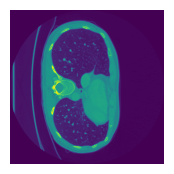

In [82]:
image_path = data_dir_list[32]
image = nib.load(image_path).dataobj[:,:, 250]
converted = image.astype(np.float32)
conv = torch.from_numpy(converted)
plt.figure(figsize=(2,2))
plt.imshow(conv)
plt.axis(False);

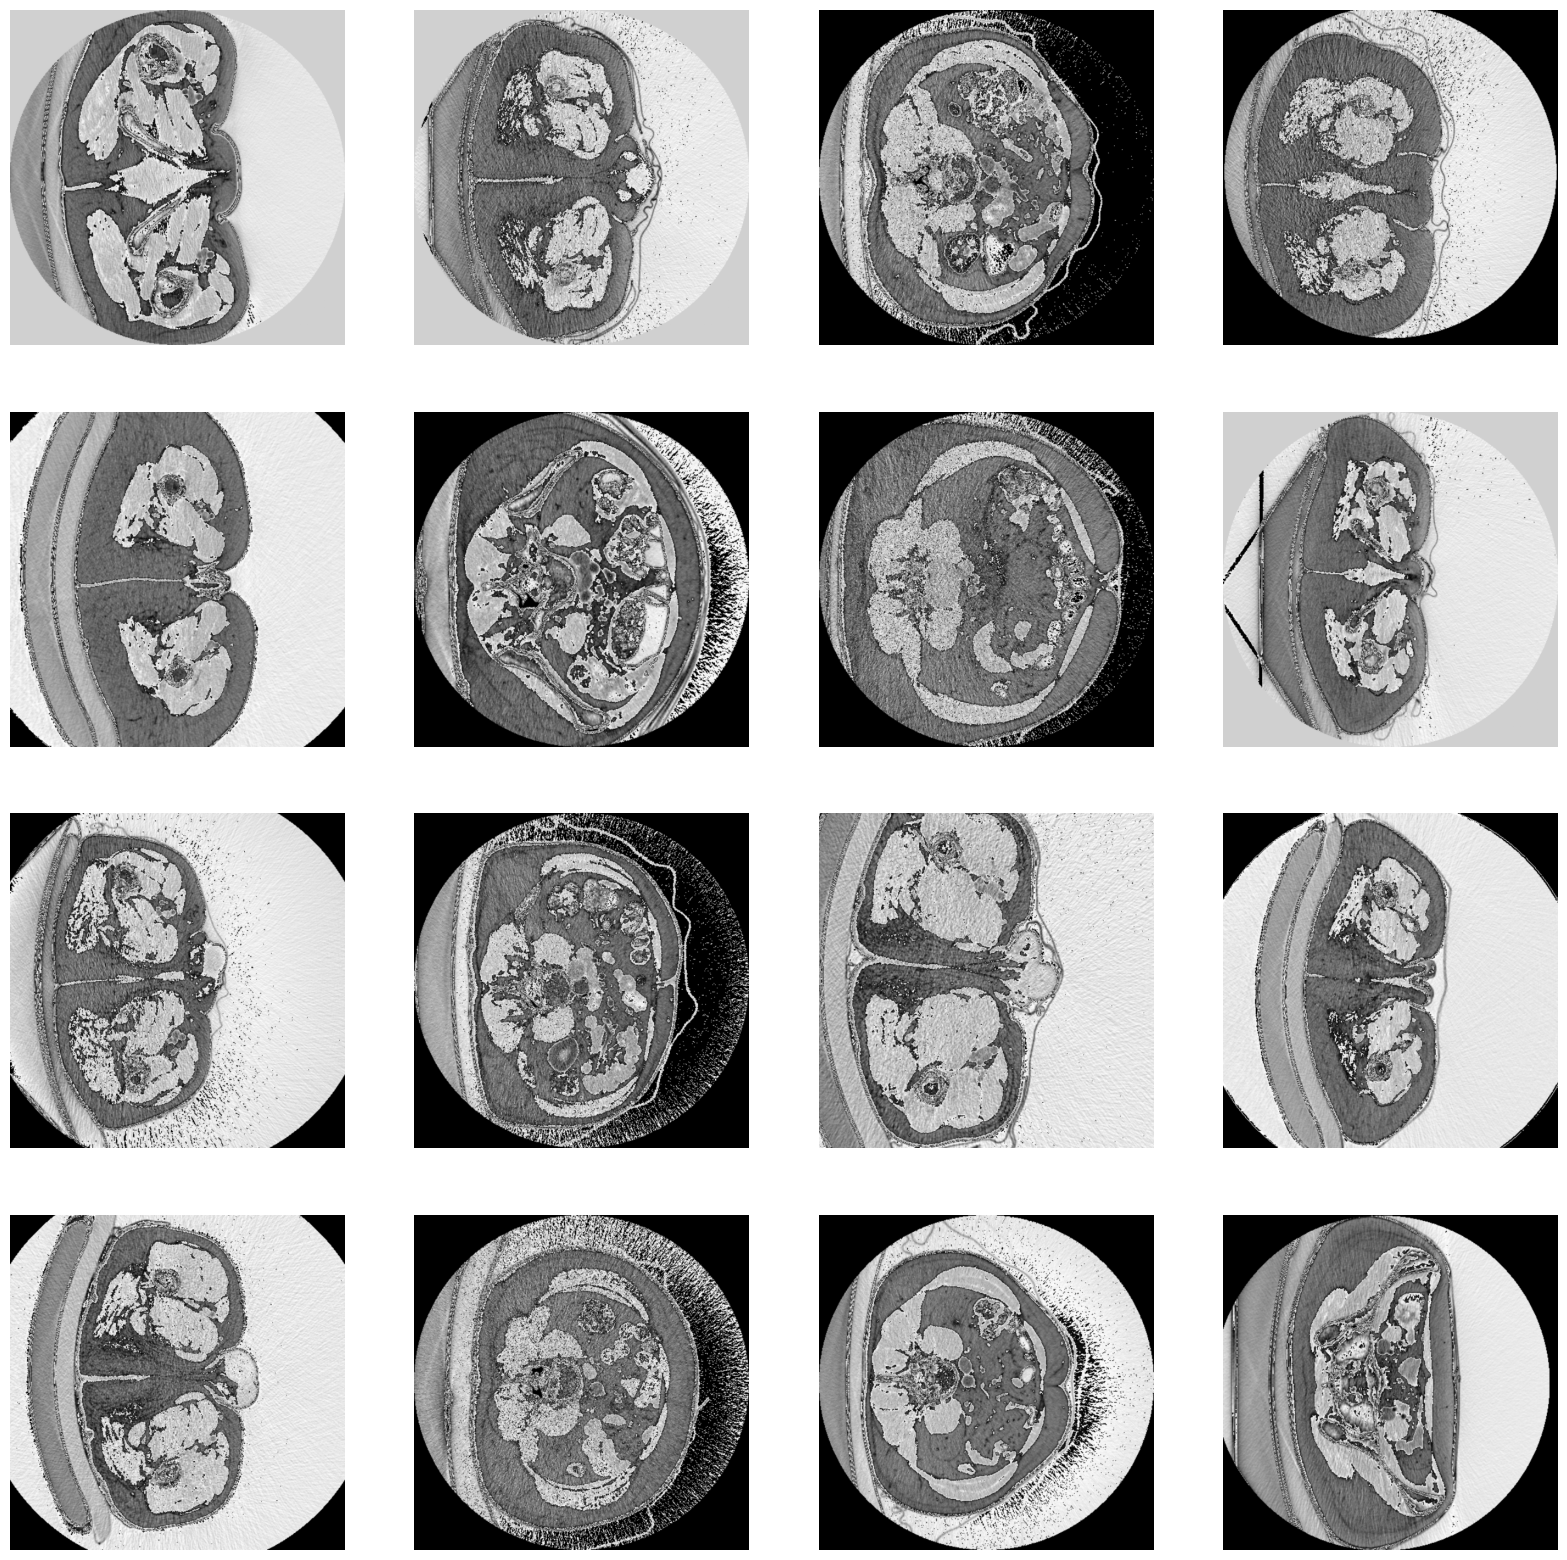

In [77]:
from random import randrange
fig = plt.figure(figsize=(20, 20))
rows, cols = 4, 4
for i in range (1, rows*cols+1):
    random_idx = randrange(0, len(train_dataset))
    img = train_dataset[random_idx][1].permute(1,2,0)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.axis(False)

In [15]:

train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle= True,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size= BATCH_SIZE,
    shuffle= False,
    num_workers= NUM_WORKERS,
    pin_memory = PIN_MEMORY,
)

len(train_dataloader), len(test_dataloader)

(11, 3)

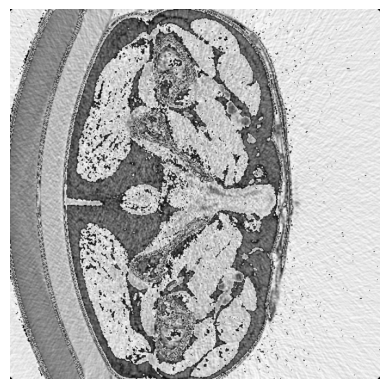

In [16]:

image_batch = next(iter(train_dataloader))
image = image_batch[0][2]
plt.imshow(image.permute(1,2,0))
plt.axis(False);

In [17]:
class listUnet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        # input: 572X572X3
        self.encoder11 = nn.Conv2d(3, 64, kernel_size= 3, padding= 1)
        self.encoder12 = nn.Conv2d(64, 64, kernel_size= 3, padding= 1)
        self.pool1 = nn.MaxPool2d(kernel_size= 2, stride= 2)

        self.encoder21 = nn.Conv2d(64, 128, kernel_size= 3, padding= 1)
        self.encoder22 = nn.Conv2d(128, 128, kernel_size= 3, padding= 1)
        self.pool2 = nn.MaxPool2d(kernel_size= 2, stride= 2)

        self.encoder31 = nn.Conv2d(128, 256, kernel_size= 3, padding= 1)
        self.encoder32 = nn.Conv2d(256, 256, kernel_size= 3, padding= 1)
        self.pool3 = nn.MaxPool2d(kernel_size= 2, stride= 2)

        self.encoder41 = nn.Conv2d(256, 512, kernel_size= 3, padding= 1)
        self.encoder42 = nn.Conv2d(512, 512, kernel_size= 3, padding= 1)
        self.pool4 = nn.MaxPool2d(kernel_size= 2, stride= 2)

        self.encoder51 = nn.Conv2d(512, 1024, kernel_size= 3, padding= 1)
        self.encoder52 = nn.Conv2d(1024,1024, kernel_size= 3, padding= 1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size= 2, stride= 2)
        self.decoder11 = nn.Conv2d(1024, 512, kernel_size= 3, padding= 1)
        self.decoder12 = nn.Conv2d(512, 512, kernel_size= 3, padding= 1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size= 2, stride= 2)
        self.decoder21 = nn.Conv2d(512, 256, kernel_size= 3, padding= 1)
        self.decoder22 = nn.Conv2d(256, 256, kernel_size= 3, padding= 1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size= 2, stride= 2)
        self.decoder31 = nn.Conv2d(256, 128, kernel_size= 3, padding= 1)
        self.decode32 = nn.Conv2d(128, 128, kernel_size= 3, padding= 1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size= 2, stride= 2)
        self.decoder41 = nn.Conv2d(128, 64, kernel_size= 3, padding= 1)
        self.decoder42 = nn.Conv2d(64, 64, kernel_size= 3, padding= 1)

        # Output layer
        self.outconv = nn.Conv2d(64, NUM_CLASSES, kernel_size= 1)

    def forward(self, x):
        # Encoder
        x_encoder11 = relu(self.encoder11(x))
        x_encoder12 = relu(self.encoder12(x_encoder11))
        x_pool1 = self.pool1(x_encoder12)

        x_encoder21 = relu(self.encoder21(x_pool1))
        x_encoder22 = relu(self.encoder22(x_encoder21))
        x_pool2 = self.pool2(x_encoder22)

        x_encoder31 = relu(self.encoder31(x_pool2))
        x_encoder32 = relu(self.encoder32(x_encoder31))
        x_pool3 = self.pool3(x_encoder32)

        x_encoder41 = relu(self.encoder41(x_pool3))
        x_encoder42 = relu(self.encoder42(x_encoder41))
        x_pool4 = self.pool4(x_encoder42)

        x_encoder51 = relu(self.encoder51(x_pool4))
        x_encoder52 = relu(self.encoder52(x_encoder51))

        # Decoder

        xu1 = self.upconv1(x_encoder52)
        xu11 = torch.cat([xu1, x_encoder42], dim= 1)
        x_decoder11 = relu(self.decoder11(xu11))
        x_decoder12 = relu(self.decoder12(x_decoder11))

        xu2 = self.upconv2(x_decoder12)
        xu22 = torch.cat([xu2, x_encoder32], dim= 1)
        x_decoder21 = relu(self.decoder21(xu22))
        x_decoder22 = relu(self.decoder22(x_decoder21))

        xu3 = self.upconv2(x_decoder22)
        xu33 = torch.cat([xu3, x_encoder22], dim= 1)
        x_decoder31 = relu(self.decoder31(xu33))
        x_decoder32 = relu(self.decoder32(x_decoder31))

        xu4 = self.upconv4(x_decoder32)
        xu44 = torch.cat([xu4, x_encoder12], dim = 1)
        x_decoder41 = relu(self.decoder41(xu44))
        x_decoder42 = relu(self.decoder42(x_decoder41))

        # Output layer
        out = self.outconv(x_decoder42)

        return out

In [18]:
model_0 = listUnet()
image.shape

torch.Size([3, 572, 572])

In [19]:
y = model_0(image)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 70 but got size 71 for tensor number 1 in the list.

In [ ]:
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr= LR)

loss_fn = torch.nn.CrossEntropyLoss()

train_steps = len(train_dataset) // BATCH_SIZE
test_steps = len(test_dataset) // BATCH_SIZE

HISTORY = {"train_loss": [], "test _loss": []}

In [20]:
print("[INFO] training the network...")

start_time = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    model_0.train()

    total_trian_loss = 0
    total_test_loss = 0

    for (i, (x, y)) in enumerate(train_dataloader):
        pred = model_0(x)
        loss = loss_fn(pred, y)


        opt.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss

    with torch.no_grad():
        model_0.eval()

        for (x,y) in test_dataloader:
            pred = model_0(x)
            totalTestLoss += loss_fn(pred, y)

        avgTrainLoss = totalTrainLoss/trainsteps
        avgTestLoss = totalTestLoss/testSteps

        

[INFO] training the network...


  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 70 but got size 71 for tensor number 1 in the list.

# Prepare the data,
### Data Preparation
1. Housefiel windowing
2. Histogram activation
3. Data Augumentation
4. Normalization

### Building of model